In [ ]:
import os
import sys

file_dir = os.getcwd()
sys.path.append(file_dir + "/../")
import torch
import numpy as np
from vi_rnn.saving import load_model
from sklearn.linear_model import LinearRegression
from evaluation.calc_stats import calc_isi_stats, calculate_correlation
from vi_rnn.saving import load_model
from vi_rnn.utils import get_orth_proj_latents
from vi_rnn.generate import generate
from vi_rnn.inference import filtering_posterior
from scipy.stats import zscore
from scipy.signal import welch
from scipy.signal.windows import hann
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

# we are using data from: https://crcns.org/data-sets/hc/hc-11/about-hc-11
# Grosmark, A.D., and Buzsáki, G. (2016). Diversity in neural firing dynamics supports both rigid and learned hippocampal sequences. Science 351, 1440–1443.
# Chen, Z., Grosmark, A.D., Penagos, H., and Wilson, M.A. (2016). Uncovering representations of sleep-associated hippocampal ensemble spike activity. Sci. Rep. 6, 32193.

In [2]:
# set seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
# load model
filename = "../models/hpc11/hc11rank4e2"
# filename = "../models/hpc11/_CNN_causal_PLRNN_Z_Date_122024_06_24_T_17_54_22"
vae,  training_params, task_params  = load_model(str(filename), backward_compat=True)
rank = vae.dim_z
vae = vae.eval()


# load spiking data
train_data = np.load("../data_untracked/train_spikes_hpc11.npy")
test_data = np.load("../data_untracked/test_spikes_hpc11.npy")
dim_x, T = test_data.shape
_, T_train = train_data.shape
print("Spiking data shape: ", test_data.shape)

# load lfp
lfp = np.load("../data_untracked/mazeLFP.npy").T

# load locations
test_locs = np.load("../data_untracked/test_locs.npy")
train_locs = np.load("../data_untracked/train_locs.npy")

using uniform init
using causal constant padding
key transition.hz not found in rnn, deleted
Spiking data shape:  (60, 4143)


In [4]:
# get latent trajectory and observation (cut first 1000 time steps)
Z,_,spikes_pred,lam =generate(vae, x = torch.from_numpy(test_data)[:, :1000].float().unsqueeze(0), dur=T, cut_off=1000, initial_state="posterior_sample")
spikes_pred = spikes_pred[0,:,:,0].T.detach().numpy()

# project latents on orthogonalised connnectivity and normalise
projection_matrix = get_orth_proj_latents(vae)
Z = projection_matrix @ Z[0, :, :, 0]
prior_Z = zscore(Z.detach().numpy(), axis=1)
# get posterior latents given test
k = 128  # number of particles
_, Qzs_filt_avg, _ = filtering_posterior(vae, x=torch.from_numpy(test_data).float().unsqueeze(0),u=torch.zeros(1,0,test_data.shape[1]),k=k,resample="systematic")

Qzs_filt_avg = Qzs_filt_avg[0].mean(axis=-1)  # average over particles
Qzs_filt_avg = (
    projection_matrix @ Qzs_filt_avg
)  # project on orthogonalised connectivity
post_Z = zscore(Qzs_filt_avg.detach().numpy(), axis=1)  # normalise

# get posterior latents given train
k = 128  # number of particles
_, Qzs_filt_avg, _ = filtering_posterior(vae, x=torch.from_numpy(train_data).float().unsqueeze(0),u=torch.zeros(1,0,train_data.shape[1]),k=k,resample="systematic")

Qzs_filt_avg = Qzs_filt_avg[0].mean(axis=-1)  # average over particles
Qzs_filt_avg = (
    projection_matrix @ Qzs_filt_avg
)  # project on orthogonalised connectivity
post_Z_train = zscore(Qzs_filt_avg.detach().numpy(), axis=1)  # normalise

In [5]:
# zcore lfp
lfp = zscore(lfp, axis=1)

# taking the mean along the channels, since channels are highly correlated
lfp = np.mean(lfp, axis=0)

# split the LFP into train and test the same as we did for spikes
train_lfp = lfp[:T_train]
test_lfp = lfp[T_train:]

fs = 39  # Hz
nperseg = 1024
f_test_lfp, psd_test_lfp = welch(
    test_lfp.reshape(-1), fs=fs, nperseg=nperseg
)  # Adjust nperseg as needed

In [6]:
# Obtain power spectral density of the prior latents

fs = 39  # Hz
nperseg = 400

f_pZ1, psd_pZ1 = welch(prior_Z[0], fs=fs, nperseg=nperseg)
f_pZ2, psd_pZ2 = welch(prior_Z[1], fs=fs, nperseg=nperseg)
f_pZ3, psd_pZ3 = welch(prior_Z[2], fs=fs, nperseg=nperseg)
f_pZ4, psd_pZ4 = welch(prior_Z[3], fs=fs, nperseg=nperseg)

In [7]:
# linear regression from latents to LFP


# Define the model and fit it
model = LinearRegression()

X = np.vstack((post_Z_train[0], post_Z_train[1], post_Z_train[2], post_Z_train[3])).T
X_test = np.vstack((post_Z[0], post_Z[1], post_Z[2], post_Z[3])).T
y = train_locs

model.fit(X, y)

y_pred = model.predict(X_test)
r2 = model.score(X_test, test_locs)

print("R2 score:", r2)
print("Corr. coef:", np.corrcoef(test_locs, y_pred)[0, 1])

R2 score: 0.7009153536723398
Corr. coef: 0.8493968841317354


In [8]:
# linear regression from latents to LFP

# Define the model and fit it
model = LinearRegression()

kw = 101

# kernel = np.ones(kw) / kw
kernel = hann(kw)
post_Z_trainks0 = np.convolve(post_Z_train[0], kernel, mode="same")
post_Z_trainks1 = np.convolve(post_Z_train[1], kernel, mode="same")
post_Z_trainks2 = np.convolve(post_Z_train[2], kernel, mode="same")
post_Z_trainks3 = np.convolve(post_Z_train[3], kernel, mode="same")

post_Zks0 = np.convolve(post_Z[0], kernel, mode="same")
post_Zks1 = np.convolve(post_Z[1], kernel, mode="same")
post_Zks2 = np.convolve(post_Z[2], kernel, mode="same")
post_Zks3 = np.convolve(post_Z[3], kernel, mode="same")

X = np.vstack((post_Z_trainks0, post_Z_trainks1, post_Z_trainks2, post_Z_trainks3)).T
X_test = np.vstack((post_Zks0, post_Zks1, post_Zks2, post_Zks3)).T
y = train_locs

model.fit(X, y)

y_pred = model.predict(X_test)
r2 = model.score(X_test, test_locs)

print("R2 score:", r2)
print("Corr. coef:", np.corrcoef(test_locs, y_pred)[0, 1])

R2 score: 0.8412427987745331
Corr. coef: 0.937230403599269


In [9]:
# get firing rates
fs = 39
fr_test = np.mean(test_data, axis=1) * fs
fr_train = np.mean(train_data, axis=1) * fs
fr_gen = np.mean(spikes_pred, axis=0) * fs

In [10]:
# Calculate correlation matrices
test_correlation = calculate_correlation(test_data.T)
gen_correlation = calculate_correlation(spikes_pred)
train_correlation = calculate_correlation(train_data.T)

# Extracting upper triangle values without the diagonal
i_upper = np.triu_indices(dim_x, k=1)
test_corr_values = test_correlation[i_upper]
gen_corr_values = gen_correlation[i_upper]
train_corr_values = train_correlation[i_upper]

In [11]:
# get ISI stats

CVs_isi_test, Means_isi_test, Std_isi_test = calc_isi_stats(test_data.T, dt=1 / fs)
CVs_isi_gen, Means_isi_gen, Std_isi_gen = calc_isi_stats(spikes_pred, dt=1 / fs)
CVs_isi_train, Means_isi_train, Std_isi_train = calc_isi_stats(train_data.T, dt=1 / fs)

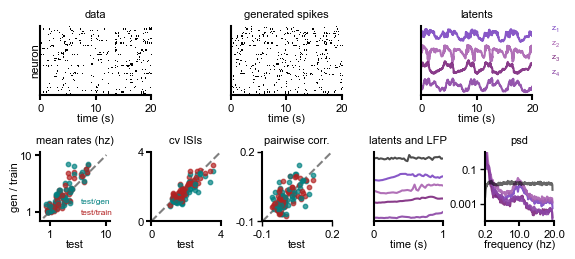

In [12]:
color1 = "#7B46C1"
color2 = "#A860AF"
color3 = "#7C277D"
color4 = "#8A44A4"
tg = "teal"
tr = "firebrick"
cmap = plt.get_cmap("tab20b")
cmap2 = plt.get_cmap("Dark2")

with mpl.rc_context(fname="matplotlibrc"):

    # Create a figure with specified size
    fig, axes = plt.subplots(2, 4, figsize=(6, 3))
    fig.subplots_adjust(hspace=0.2, wspace=0.6)

    ax1 = axes[0, 0]
    ax2 = axes[0, 2]
    ax3 = axes[0, 1]
    ax4 = axes[1, 0]
    ax5 = axes[1, 1]
    ax6 = axes[1, 2]
    ax7 = axes[1, 3]
    ax8 = axes[0, 3]

    # extract the width gap
    gap = ax5.get_position().x0 - ax4.get_position().x1

    # manually set the position for ax8
    pos = axes[1, 3].get_position()  # Get position of the third plot
    ax8.set_position([pos.x0 + pos.width + gap, pos.y0, pos.width, pos.height])

    # manually adjust the locations of wider plots
    width_scaling_factor = 1.6
    new_positions = []

    for i, ax in enumerate(axes[0, :3]):
        pos = ax.get_position()
        if i == 0:
            new_positions.append(
                [pos.x0, pos.y0, pos.width * width_scaling_factor, pos.height]
            )
        else:
            new_positions.append(
                [
                    new_positions[i - 1][0] + new_positions[i - 1][2] + gap * 4 / 2.1,
                    pos.y0,
                    pos.width * width_scaling_factor,
                    pos.height,
                ]
            )

    for i, ax in enumerate(axes[0, :3]):
        ax.set_position(new_positions[i])

    # data spikes
    sec = 20
    init = 750
    duration = sec * 40
    ax1.imshow(
        test_data[:, init : init + duration],
        aspect="auto",
        cmap="Greys",
        interpolation="none",
        vmax=1,
    )
    ax1.set_xticks([0, 10 * 40, 20 * 40])
    ax1.set_xticklabels([0, 10, 20])
    ax1.set_yticks([])
    ax1.set_title("data")
    ax1.set_ylabel("neuron")
    ax1.set_xlabel("time (s)")

    # generated spikes
    ax3.imshow(
        spikes_pred[init : init + duration, :].T,
        aspect="auto",
        cmap="Greys",
        interpolation="none",
        vmax=1,
    )
    ax3.set_xticks([0, 10 * 40, 20 * 40])
    ax3.set_xticklabels([0, 10, 20])
    ax3.set_title("generated spikes")
    ax3.set_xlabel("time (s)")
    ax3.set_yticks([])

    # latents
    t = np.linspace(0, sec, duration)
    ax2.plot(
        t, prior_Z[0][init : init + duration] + 5, alpha=0.9, label="Z1", color=color1
    )
    ax2.plot(t, prior_Z[1][init : init + duration], alpha=0.9, label="Z2", color=color2)
    ax2.plot(
        t, prior_Z[2][init : init + duration] - 5, alpha=0.9, label="Z3", color=color3
    )
    ax2.plot(
        t, prior_Z[3][init : init + duration] - 10, alpha=0.9, label="Z4", color=color4
    )
    ax2.set_xlim(0, sec)
    ax2.set_yticks([])
    ax2.set_xticks([0, 10, 20])
    ax2.set_yticks([])
    ax2.set_xlabel("time (s)")
    ax2.set_title("latents")

    # coefficient of variation
    n_dots = len(CVs_isi_test)
    zorders = np.arange(n_dots * 2)
    np.random.shuffle(zorders)
    for i in range(n_dots):
        ax5.scatter(
            CVs_isi_test[i],
            CVs_isi_gen[i],
            s=10,
            alpha=0.7,
            color=tg,
            zorder=zorders[i],
        )
        ax5.scatter(
            CVs_isi_test[i],
            CVs_isi_train[i],
            s=10,
            alpha=0.7,
            color=tr,
            label="train",
            zorder=zorders[i + n_dots],
        )

    ax5.plot([0, 4], [0, 4], color="gray", linestyle="--", zorder=0)
    ax5.set_title("cv ISIs")
    ax5.set_xticks([0, 4])
    ax5.set_yticks([0, 4])
    ax5.set_xlabel("test")
    ax5.set_xlim([0, 4])
    ax5.set_ylim([0, 4])

    # mean rates
    ax4.plot(
        np.linspace(0, 10, 20),
        np.linspace(0, 10, 20),
        color="gray",
        linestyle="--",
        zorder=0,
    )
    n_dots = len(fr_test)
    zorders = np.arange(n_dots * 2)
    np.random.shuffle(zorders)
    for i in range(n_dots):
        ax4.scatter(fr_test[i], fr_gen[i], s=10, alpha=0.7, color=tg, zorder=zorders[i])
        ax4.scatter(
            fr_test[i],
            fr_train[i],
            s=10,
            alpha=0.7,
            color=tr,
            zorder=zorders[i + n_dots],
        )

    ax4.set_title("mean rates (hz)")
    ax4.set_xticks([1, 10])
    ax4.set_yticks([1, 10])
    ax4.set_xlabel("test")
    ax4.set_ylabel("gen / train")

    # custom legend labels and colors
    legend_labels = ["test/gen", "test/train"]
    legend_colors = [tg, tr]

    # add custom legend
    legend_elements = [
        plt.Line2D([0], [0], color=color, lw=0, label=label)
        for color, label in zip(legend_colors, legend_labels)
    ]
    legend = ax4.legend(
        handles=legend_elements,
        handletextpad=0,
        handlelength=0,
        fancybox=True,
        loc="upper right",
        bbox_to_anchor=(1.16, 0.45),
        fontsize=6,
    )

    for text, color in zip(legend.get_texts(), legend_colors):
        text.set_color(color)

    # pairwise correlation
    ax6.plot([-0.1, 0.2], [-0.1, 0.2], color="gray", linestyle="--", zorder=0)
    dots = len(test_corr_values)
    zorders = np.arange(n_dots * 2)
    np.random.shuffle(zorders)
    for i in range(n_dots):
        ax6.scatter(
            test_corr_values[i],
            gen_corr_values[i],
            s=10,
            alpha=0.7,
            color=tg,
            zorder=zorders[i],
        )
        ax6.scatter(
            test_corr_values[i],
            train_corr_values[i],
            s=10,
            alpha=0.7,
            color=tr,
            label="train",
            zorder=zorders[i + n_dots],
        )

    ax6.tick_params(axis="x", which="both", width=1)
    ax6.tick_params(axis="y", which="both", width=1)
    ax6.set_title("pairwise corr.")
    ax6.set_xlabel("test")
    ax6.set_yticks([-0.1, 0.2])
    ax6.set_yticklabels(["-0.1", "0.2"])
    ax6.set_xticks([-0.1, 0.2])
    ax6.set_xticklabels(["-0.1", "0.2"])
    ax6.set_xlim([-0.1, 0.2])
    ax6.set_ylim([-0.1, 0.2])
    # psd
    (line1,) = ax8.semilogy(
        f_pZ1, psd_pZ1, color=color1, alpha=0.9, zorder=0, label="z 2"
    )
    (line2,) = ax8.semilogy(
        f_pZ2, psd_pZ2, color=color2, alpha=0.9, zorder=0, label="z 3"
    )
    (line3,) = ax8.semilogy(
        f_pZ3, psd_pZ3, color=color3, alpha=0.9, zorder=0, label="z 1"
    )
    (line4,) = ax8.semilogy(
        f_pZ4, psd_pZ4, color=color4, alpha=0.9, zorder=0, label="z 1"
    )
    (line5,) = ax8.semilogy(
        f_test_lfp, psd_test_lfp, color="black", alpha=0.6, zorder=0, label="LFP"
    )
    ax8.set_xlim([0, 20])
    ax8.set_ylim([10**-4, 1])
    ax8.set_title("psd")
    ax8.set_xlabel("frequency (hz)")
    ax8.tick_params(axis="y", which="both", width=1)

    # custom legend handles. note: legends were manually adjusted using illustrator afterwards to include the LFP signal
    legend_labels = ["$z_1$", "$z_2$", "$z_3$", "$z_4$"]
    legend_colors = [color1, color2, color3, color4]

    legend = ax8.legend(
        legend_labels,
        handletextpad=0,
        handlelength=0,
        fancybox=True,
        loc="upper right",
        bbox_to_anchor=(1.2, 2.95),
    )
    for text, color in zip(legend.get_texts(), legend_colors):
        text.set_color(color)

    ax8.set_yticks([0.001, 0.1])
    ax8.set_yticklabels(["0.001", "0.1"])
    ax8.set_xticks([0.2, 10, 20])

    # LFP and zoomed latents
    init = int(18.3 * 40) + 1160
    duration = 1 * 40
    t = np.linspace(0, 1, duration)

    # note: we shifted the signals for better visualization
    ax7.plot(
        t, prior_Z[0][init : init + duration] + 5, alpha=0.9, label="Z1", color=color1
    )
    ax7.plot(t, prior_Z[1][init : init + duration], alpha=0.9, label="Z4", color=color2)
    ax7.plot(
        t, prior_Z[2][init : init + duration] - 5, alpha=0.9, label="Z3", color=color3
    )
    ax7.plot(
        t, prior_Z[3][init : init + duration] - 10, alpha=0.9, label="Z2", color=color4
    )

    cc = test_lfp[init : init + duration] + 12
    ax7.plot(t, cc, alpha=0.7, label="LFP", color="black")
    ax7.set_xlim([0, 1])
    ax7.set_xticks([0, 1])
    ax7.set_yticks([])
    ax7.set_xlabel("time (s)")
    ax7.set_title("latents and LFP")

    plt.gcf().set_size_inches(5.2, 3)

    ax1.set_box_aspect(0.625)
    ax2.set_box_aspect(0.625)
    ax3.set_box_aspect(0.625)
    ax7.set_box_aspect(1)
    ax4.set_box_aspect(1)
    ax5.set_box_aspect(1)
    ax6.set_box_aspect(1)
    ax8.set_box_aspect(1)

    plt.savefig("../figures/hpc11_main.png", dpi=300)
    plt.savefig("../figures/hpc11_maincorfon.pdf", dpi=300)

    plt.show()

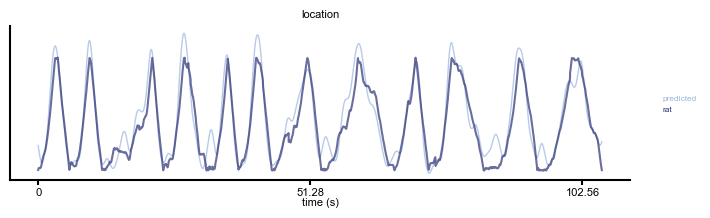

In [13]:
with mpl.rc_context(fname="matplotlibrc"):

    pr = "#9BB5DE"
    rat = "#2B3073"
    plt.figure(figsize=(8, 2))
    plt.plot(y_pred, color=pr, alpha=0.7, label="predicted", linewidth=1)
    plt.plot(test_locs, alpha=0.7, color=rat, label="rat", linewidth=1.5)
    plt.legend()

    # divide x axis by fs to convert to seconds
    # but note that we cropped the signal and only show
    # the first 30 seconds in the main figure to make the plot more readable
    plt.xticks([0, 2000, 4000], [0, round(2000 / fs, 2), round(4000 / fs, 2)])
    legend_labels = ["predicted", "rat"]
    legend_colors = [pr, rat]

    legend = plt.legend(
        legend_labels,
        handletextpad=0,
        handlelength=0,
        fancybox=True,
        loc="upper right",
        bbox_to_anchor=(1.12, 0.6),
    )
    for text, color in zip(legend.get_texts(), legend_colors):
        text.set_color(color)
    plt.xlabel("time (s)")
    plt.yticks([])
    plt.title("location")
    plt.show()